## Imports

In [1]:
import numpy as np
from numpy import pi, cos, sin, array, exp

In [2]:
from scipy import signal

In [3]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
np.set_printoptions(precision=3, suppress=True)

In [4]:
import warnings
from warnings import filterwarnings
filterwarnings('ignore', category=UserWarning)

## Modulation model

#### Symbol mapping

In [5]:
class Mapper:
    
    def __init__(self):
        self.BPSK_LUT = array([-1 -1j, 1 + 1j])/np.sqrt(2)
        self.QPSK_LUT = array([-1-1j, -1+1j, 1-1j, 1+1j])/np.sqrt(2)
        self.PSK8_LUT = array([exp(3j*pi/4), -1, 1j, exp(1j*pi/4), 
                               -1j, exp(-3j*pi/4), exp(-1j*pi/4), 1])
        # The scaling factor for 16QAM is sqrt(10), 
        # since avg_power = [4*2 + 8*10 + 4*18]/16 = 10
        # Also the LUT for 16QAM in the book matlab code has an error
        self.QAM16_LUT = array([-3-3j, -3-1j, -3+3j, -3+1j,
                                -1-3j, -1-1j, -1+3j, -1+1j,
                                 3-3j, 3-1j, 3+3j, 3+1j,
                                 1-3j, 1-1j, 1+3j, 1-1j])/np.sqrt(10)
        
    def convert_bit_array_to_int(self, array_of_bits):
        '''
        >>> convert_bit_array_to_int(  np.array([0, 1, 1, 0]) )
        6
        '''
        bit_str = np.array2string(array_of_bits, separator='')[1:-1] #Sliced to remove brackets
        return int(bit_str, 2)
    
    
    def convert_to_symbols(self, bitstream, bits_in_symbol, LUT):
        num_symbols = len(bitstream)//bits_in_symbol
        truncated_bitstream = bitstream[:num_symbols*bits_in_symbol]
        
        if len(truncated_bitstream) != len(bitstream):
            print(f'Truncating {len(bitstream) - len(truncated_bitstream)} bits at the end.')
        
        symbol_bits = np.split(truncated_bitstream, num_symbols) # list of sub-arrays
        symbols = array( [LUT[self.convert_bit_array_to_int(bits)]
                          for bits in symbol_bits] )
        return symbols
        
        
    def bpsk(self, bitstream):
        return self.convert_to_symbols(bitstream, bits_in_symbol=1, LUT=self.BPSK_LUT)
    
    def qpsk(self, bitstream):
        return self.convert_to_symbols(bitstream, bits_in_symbol=2, LUT=self.QPSK_LUT)
    
    def psk8(self, bitstream):
        return self.convert_to_symbols(bitstream, bits_in_symbol=3, LUT=self.PSK8_LUT)
    
    def qam16(self, bitstream):
        return self.convert_to_symbols(bitstream, bits_in_symbol=4, LUT=self.QAM16_LUT)

    
# Create a modulator
mapper = Mapper()

In [6]:
random_bits = np.random.choice([0, 1], 10)
print('Bits: {}'.format(random_bits))

qpsk = mapper.qpsk(random_bits)
print('QPSK symbols: {}'.format(qpsk*np.sqrt(2)))

Bits: [1 0 0 0 1 1 1 0 1 1]
QPSK symbols: [ 1.-1.j -1.-1.j  1.+1.j  1.-1.j  1.+1.j]


#### Waveform 

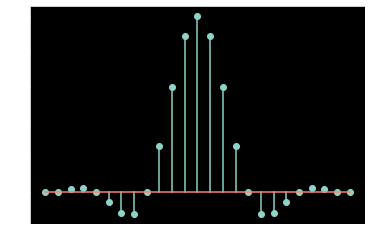

In [7]:
def rcosine(osr, β):
    # All calculations are normalized by T
    duration = (-3, 3)
    N = osr*(duration[1] - duration[0]) + 1
    t = np.linspace(*duration, N)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore') # For Divide by zero
        rcos_filt = np.sinc(t) * cos(pi*β*t) / (1-(2*β*t)**2)
    rcos_filt[np.isinf(rcos_filt)] = (pi/4)*np.sinc(1/(2*β))
    return rcos_filt

plt.stem(rcosine(4, 0.5));

In [8]:
def zero_stuff(symbols, osr):
    num_symbols = len(symbols)
    sample_stream = np.zeros(num_symbols * osr, complex)
    sample_stream[::osr] = symbols
    return sample_stream

def waveform_mapping(symbols, osr=4, beta=0.5):
    sample_stream = zero_stuff(symbols, osr)
    pulse = rcosine(osr, beta)
    output_samples = signal.lfilter(pulse, 1, sample_stream)
    return output_samples